# 1. Train and Save model

### 1.1. Load and Display an Image
This code loads and displays a pair of images and segmentation masks.


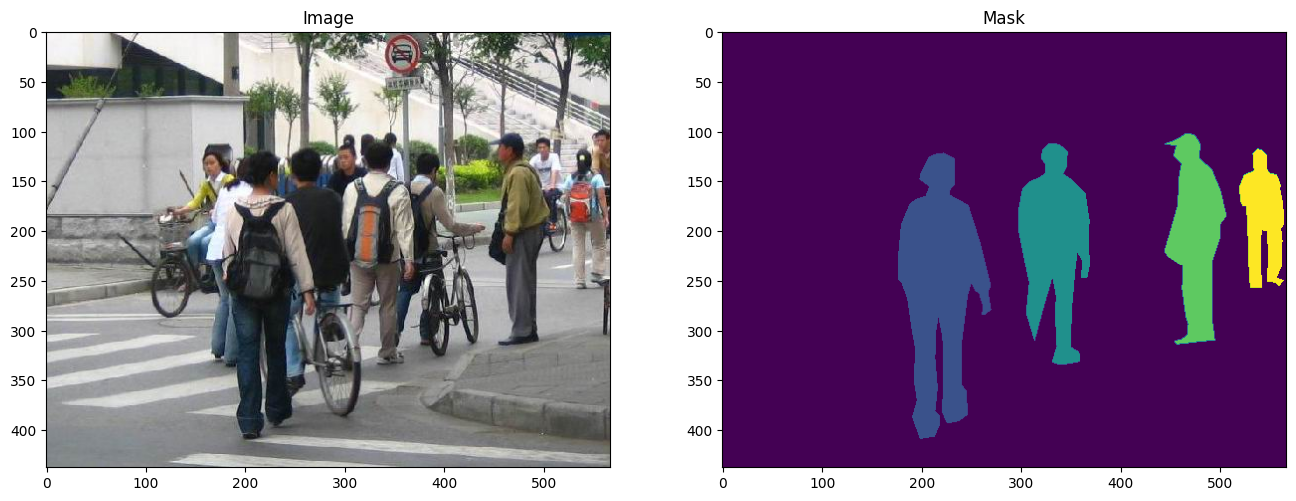

In [1]:
import matplotlib.pyplot as plt
from torchvision.io import read_image


image = read_image("data/PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image("data/PennFudanPed/PedMasks/FudanPed00046_mask.png")

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0));

### 1.2. Writing a custom dataset for PennFudan
This section defines a torch.utils.data.Dataset for the PennFudan dataset.


In [15]:
import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F
from typing import Tuple, Dict


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root: str, transforms=None) -> None:
        self.root = root
        self.transforms = transforms
        self.images = sorted(os.listdir(os.path.join(root, "PNGImages")))
        self.masks = sorted(os.listdir(os.path.join(root, "PedMasks")))
        
    def __len__(self) -> int:
        """Returns the total number of samples."""
        return len(self.images)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
        """Returns one sample of data and target"""
        # Load images and masks
        image_path = os.path.join(self.root, "PNGImages", self.images[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        image = read_image(image_path)
        mask = read_image(mask_path)
        # Instances are encoded as different colors
        object_ids = torch.unique(mask)
        # First id is the background, so remove it
        object_ids = object_ids[1:]
        num_objects = len(object_ids)
        
        # Split the color-encoded mask into a set of binary masks
        masks = (mask == object_ids[:, None, None]).to(torch.uint8)
        
        # Get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)
        
        # There is only one class
        labels = torch.ones((num_objects,), dtype=torch.int64)
        
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # Suppose all instances are not crowd
        iscrowd = torch.zeros((num_objects,), dtype=torch.int64)
        
        # Wrap sample and targets into torchvision tv_tensors:
        image = tv_tensors.Image(image)
        
        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(image))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        # Transform if necessary
        if self.transforms is not None:
            image, target = self.transforms(image, target)
            
        return image, target

### 1.3. Defining a pre-trained model
 We want to finetune from a pre-trained model, given that our dataset is very small. The model chosen is the Mask R-CNN, which is based on top of Faster R-CNN. Faster R-CNN is a model that predicts both bounding boxes and class scores for potential objects in the image. Mask R-CNN adds an extra branch into Faster R-CNN, which also predicts segmentation masks for each instance.

In [16]:
import torchvision
import torch

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes:int, seed:int=42):
    """
    Creates a Mask R-CNN object detection and instance segmentation model with a ResNet-50-FPN backbone.
    :params num_classes: number of classes in box_predictor and mask_predictor.
            seed: random seed value. Defaults to 42.
    :return: Mask R-CNN model.
    """
    # Load pre-trained model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    
    # Freeze all layer in base model
    for param in model.parameters():
        param.requires_grad = False
    
    # Set random seed
    torch.manual_seed(seed)
    
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features 
    # Replace the classifier with a new one, that has num_classes which is user-defined
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Now get the number of input features for the mask classifier
    #in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    #hidden_layer = 256
    #model.roi_heads.mask_predictor = MaskRCNNPredictor(
    #    in_features_mask,
    #    hidden_layer,
    #    num_classes)
    
    return model

### 1.4. Load Helper Functions

In [17]:
# Helper functions to simplify training and evaluating detection models
if os.path.exists("helper_functions/engine.py"):
    print(f"Files already downloaded.")
else:
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
    os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

Files already downloaded.


### 1.5. Define Data Transformations

In [18]:
from torchvision.transforms import v2 as T

def get_transform(train: bool):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

### 1.6. Testing forward() method
Before iterating over the dataset, it’s good to see what the model expects during training and inference time on sample data.

In [19]:
from helper_functions import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset("data/PennFudanPed", get_transform(train=True))
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn,
)

# For training
images, targets = next(iter(dataloader))
images = [image for image in images]
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)
print(predictions[0])

{'loss_classifier': tensor(0.0765, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0271, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0200, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0007, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


### 1.7. Train model
This is the main function which performs the training and the validation.

In [24]:
from helper_functions.engine import train_one_epoch, evaluate

# Setup device-agnostic code
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Our dataset has two classes only - background and person
num_classes = 2

# Use our dataset and defined transformations
dataset = PennFudanDataset("data/PennFudanPed", get_transform(train=True))
dataset_test = PennFudanDataset('data/PennFudanPed', get_transform(train=False))

# Split the dataset in train and test sets
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# Define training and validation data loaders
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn,
)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn,
)

# Get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# Move model to the right device
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.005,
                            momentum=0.9,
                            weight_decay=0.0005)

# Construct a lr scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

# Let's train it just for 2 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq=10)
    # Update the learning rate
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model, dataloader_test, device)
    
print("That's it!")

Epoch: [0]  [ 0/60]  eta: 0:00:28  lr: 0.000090  loss: 1.0999 (1.0999)  loss_classifier: 0.9497 (0.9497)  loss_box_reg: 0.1270 (0.1270)  loss_objectness: 0.0221 (0.0221)  loss_rpn_box_reg: 0.0011 (0.0011)  time: 0.4677  data: 0.0325  max mem: 1472
Epoch: [0]  [10/60]  eta: 0:00:07  lr: 0.000936  loss: 1.0019 (0.9105)  loss_classifier: 0.6344 (0.6165)  loss_box_reg: 0.2251 (0.2745)  loss_objectness: 0.0146 (0.0144)  loss_rpn_box_reg: 0.0043 (0.0051)  time: 0.1594  data: 0.0309  max mem: 1472
Epoch: [0]  [20/60]  eta: 0:00:05  lr: 0.001783  loss: 0.5982 (0.7183)  loss_classifier: 0.2980 (0.4399)  loss_box_reg: 0.2251 (0.2586)  loss_objectness: 0.0146 (0.0146)  loss_rpn_box_reg: 0.0042 (0.0053)  time: 0.1257  data: 0.0272  max mem: 1472
Epoch: [0]  [30/60]  eta: 0:00:04  lr: 0.002629  loss: 0.4911 (0.6804)  loss_classifier: 0.2500 (0.3977)  loss_box_reg: 0.2309 (0.2596)  loss_objectness: 0.0148 (0.0174)  loss_rpn_box_reg: 0.0042 (0.0057)  time: 0.1274  data: 0.0272  max mem: 1472
Epoch: [

### 1.8. Display Training Results
This code visualizes the results of the model’s predictions using bounding boxes and masks on sample images.


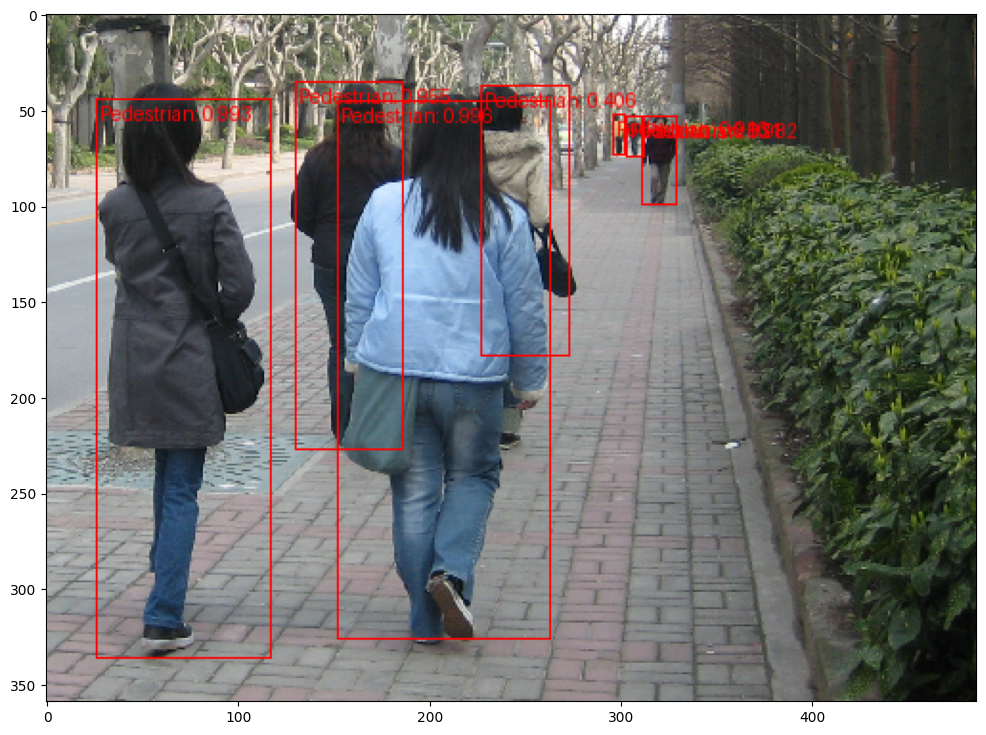

In [33]:
import matplotlib.pyplot as plt
import random

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from timeit import default_timer as timer

#image_path = "data/example_image.jpg"
image_path = os.path.join("data/PennFudanPed/PNGImages", random.choice(os.listdir("data/PennFudanPed/PNGImages")))
image = read_image(image_path)
eval_transform = get_transform(train=False)

model.eval()
with torch.inference_mode():
    x = eval_transform(image)
    # Convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x,])
    pred = predictions[0]
    
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8) # Useless??
image = image[:3, ...]
filtered_scores_idx = torch.nonzero(pred["scores"] > 0.3).squeeze()
if filtered_scores_idx.dim() == 0:
    pred_labels = [f"Pedestrian: {score:.3f}" for label, score in zip(pred["labels"][filtered_scores_idx].unsqueeze(0), pred["scores"][filtered_scores_idx].unsqueeze(0))]
    pred_boxes = pred["boxes"][filtered_scores_idx].long().unsqueeze(0)
else:
    pred_labels = [f"Pedestrian: {score:.3f}" for label, score in zip(pred["labels"][filtered_scores_idx], pred["scores"][filtered_scores_idx])]
    pred_boxes = pred["boxes"][filtered_scores_idx].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

#masks = (pred["masks"] > 0.7).squeeze(1)
#output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

### 1.9. Save Trained Model
After training, the model's state is saved in a file for use in deployment.

In [34]:
# Save model
model_path = "models/fasterrcnn_resnet50_fpn_PennFudanPed.pth"
torch.save(model.state_dict(), model_path)